In [1]:
import warnings
warnings.simplefilter("ignore")

# Slippy maps

In [2]:
import folium
from folium.plugins import Fullscreen


lon, lat = -25, -25
m = folium.Map(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Topo_Map/MapServer/tile/{z}/{y}/{x}",
    attr="ESRI",
    location=[lat, lon],
    zoom_start=5,
)

m

<div class="alert alert-success" style="font-size:80%">
<b>Exercise: Explore `folium.plugins`.</b><br><br>

check:

- `folium.pluing.Draw`
- `folium.plugins.TimestampedWmsTileLayers`
- `folium.plugins.Fullscreen`

</div>

In [3]:
import folium.plugins


"""..."""

'...'

In [4]:
import folium

lon, lat = -86.276, 30.935 

m = folium.Map(
    location=[lat, lon],
    tiles="Cartodb Positron",
    zoom_start=5
)

In [5]:
from pathlib import Path
import json

path = Path("data")

f = path.joinpath("stations.geojson").open()
stations = json.load(f)

f = path.joinpath("hfradar.geojson").open()
hfradar = json.load(f)

In [6]:
icon_size = (14, 14)

for feature in stations["features"]:
    lon, lat = feature["geometry"]["coordinates"]
    icon_url = feature["properties"]["icon"]
    popup = feature["properties"]["popupcontent"]

    icon = folium.features.CustomIcon(
        icon_url,
        icon_size=(14, 14)
    )

    marker = folium.map.Marker(
        location=[lat, lon],
        icon=icon,
        popup=folium.map.Popup(popup)
    )
    m.add_child(marker)

In [7]:
for feature in hfradar["features"]:
    if feature["geometry"]["type"] == "Point":
        lon, lat = feature["geometry"]["coordinates"]
        icon_url = feature["properties"]["icon"]
        popup = feature["properties"]["popupcontent"]

        icon = folium.features.CustomIcon(
            icon_url,
            icon_size=(14, 14)
        )
        marker = folium.Marker(
            location=[lat, lon],
            icon=icon,
            popup=folium.Popup(popup)
        )
        m.add_child(marker)
    elif feature["geometry"]["type"] == "Polygon":
        gjson = folium.features.GeoJson(feature)
        m.add_child(gjson)

In [8]:
m

### For more examples please check folium's gallery

[http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples](http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples)

In [9]:
import gridgeo


url = ("http://amb6400b.stccmop.org:8080/thredds/dodsC/"
       "model_data/forecast.nc")

grid = gridgeo.GridGeo(url, standard_name="sea_surface_temperature")

In [10]:
grid.mesh

'ugrid'

The grid has 59906 polygons, showing the first 5.


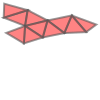

In [11]:
print(f"The grid has {len(grid.polygons)} polygons, "
      "showing the first 5.")

grid.geometry[:10]

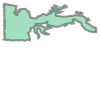

In [12]:
grid.outline

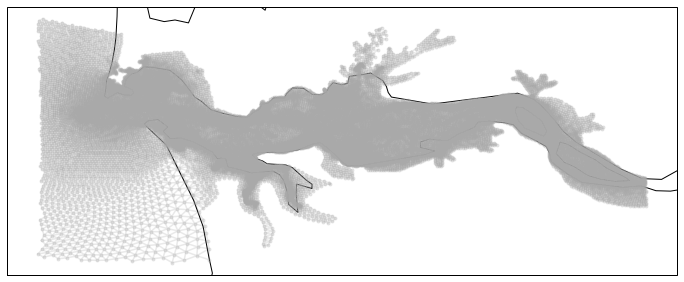

In [13]:
%matplotlib inline
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12),
                       subplot_kw={'projection': ccrs.PlateCarree()})

kw = dict(marker='.', linestyle='-', alpha=0.25, color='darkgray')
ax.triplot(grid.triang, **kw)
ax.coastlines(resolution='10m');

In [14]:
m = folium.Map()

folium.GeoJson(grid.outline).add_to(m)

m.fit_bounds(m.get_bounds())

In [15]:
m

In [16]:
# %load 03-folium_ipyleaflet-extra-sol.py
import fiona

fname = path.joinpath("model_grid", "grid.shp")

schema = {
    "geometry": "Polygon",
    "properties": {"name": f"str:{len(grid.mesh)}"}
}

with fiona.open(str(fname), "w", "ESRI Shapefile", schema) as f:
    f.write(
        {
            "geometry": grid.outline.__geo_interface__,
            "properties": {"name": grid.mesh}
        }
    )


### ipyleaflet

In [17]:
from ipyleaflet import Map, Velocity, TileLayer, basemaps
import xarray as xr

zoom = 3

m = Map(
    center=[44, -130],
    zoom=3,
    interpolation="nearest",
    basemap=basemaps.CartoDB.DarkMatter,
)

In [18]:
ds = xr.open_dataset("data/wind-global.nc")

display_options = {
    "velocityType": "Global Wind",
    "displayPosition": "bottomleft",
    "displayEmptyString": "No wind data"
}
wind = Velocity(
    data=ds, 
    zonal_speed="u_wind", meridional_speed="v_wind", 
    latitude_dimension="lat", longitude_dimension="lon", 
    velocity_scale=0.01, max_velocity=20, 
    display_options=display_options
)
m.add_layer(wind)

In [19]:
m

Map(basemap={'url': 'http://c.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}.png', 'max_zoom': 20, 'attribution': …

### Extras

In [20]:
import pandas as pd


url = (
    "https://whereonmars.carto.com/api/v2/sql?"
    "filename=themartian&"
    "q=SELECT+*+FROM+(select+*+from+public.themartian)+as+subq+&"
    "format=csv&"
    "bounds=&"
    "api_key=&"
    "skipfields=the_geom_webmercator"
)

df = pd.read_csv(url, index_col="cartodb_id").sort_index().drop("the_geom", axis=1)

In [21]:
import folium
from folium.plugins import Draw, Fullscreen

opm_attr = '<a href="https://github.com/openplanetary/opm/wiki/OPM-Basemaps" target="blank">OpenPlanetaryMap</a>'

m = folium.Map(
    attr=f"NASA/MOLA |{opm_attr}",
    max_zoom=5,
    tiles="https://s3-eu-west-1.amazonaws.com/whereonmars.cartodb.net/mola-color/{z}/{x}/{-y}.png"
)

Fullscreen().add_to(m);

In [22]:
kw = {
    "fill": True,
    "color": "white",
    "fill_color": "white",
    "fill_opacity": 1,
}

for k, row in df.iterrows():
    title = row["title"] if isinstance(row["title"], str) else None
    location = [row["lat"], row["lng"]]
    if title:
        folium.CircleMarker(location=location, popup=title, radius=5, **kw).add_to(m)
    else:
        folium.CircleMarker(location=location, radius=1, **kw).add_to(m)

In [23]:
m